<h2>Relis R code analysis</h2>

<h4><u>Parsing and beautifing data</u></h4>

In [ ]:
# Install and load the necessary packages
packgs <- c("tidyverse", "qdapRegex", "data.table", "janitor", "dplyr", "ggplot2", "cowplot", "psych")
install.packages(setdiff(packgs, unique(data.frame(installed.packages())$Package)))
lapply(packgs, library, character.only = TRUE)

In [ ]:
# Importing data.csv
relis_data <- read.csv("../data/relis_classification_CV.csv", header = TRUE) # Replace this with the name of your imported data file
print(relis_data)

In [ ]:
## Config file
# Beautifying Title
config_file <- data.frame(
    Column_name = c("Transformation.name", "Domain", "Transformation.Language", "Source.language", "Target.language", "Scope", "Industrial", "Bidirectional", "Targeted.year", "Note", "Publication.year", "Venue", "Search.Type"),
    Scale = c("Text", "Nominal", "Nominal", "Nominal", "Nominal", "Nominal", "Nominal", "Nominal", "Continuous", "Text", "Continuous", "Nominal", "Nominal")
)
print(config_file)

In [ ]:
# Split config file based on data type
nominal_df <- subset(config_file, Scale == "Nominal")
continuous_df <- subset(config_file, Scale == "Continuous")
print(nominal_df)
print(continuous_df)

<h4><u>DESCRIPTIVE STATS</u></h4>

<h5 style="color:orange">Functions<h5>

In [ ]:
# Function to extract current column and organize data
beautify_data_desc <- function(data, config_file, i) {
    # Split the values by the "|" character
    split_values <- str_split(data[[config_file$Column_name[i]]], "\\|")
    # Flatten the split values into a single vector and remove leading and trailing whitespaces
    flattened_values <- str_trim(unlist(split_values))

    # Generate the frequency table
    table_to_add <- tabyl(flattened_values)

    table_to_add["percent"] <- lapply(table_to_add["percent"], function(x) x * 100)
    colnames(table_to_add) <- c("Value", "n", "Percentage")

    return(table_to_add)
}

beautify_data_desc_cont <- function(data, config_file, i) {
    table_to_add <- data[, config_file$Column_name[i]]
    table_to_add <- data.frame(data = table_to_add)

    return(table_to_add)
}

# Function to generate bar plots
generate_bar_plot <- function(data, config_file, i) {
    table_to_add <- beautify_data_desc(data, config_file, i)
    p <- ggplot(data = table_to_add, aes(x = Value, y = Percentage, fill = n)) +
        geom_bar(stat = "identity") +
        labs(title = paste(nominal_df$Column_name[i], "~ Bar plot"), x = config_file$Title[i], y = "Percentage") +
        theme_minimal()

    return(p)
}

# Function to generate box plots
generate_box_plot <- function(data, config_file, i) {
    table_to_add <- beautify_data_desc_cont(data, config_file, i)
 
    p <- ggplot(table_to_add, aes(x = "x", y = data)) +
        geom_boxplot() +
        stat_summary(fun = "mean", geom = "point", shape = 8, size = 2, color = "red") +
        labs(title = paste(config_file$Title[[i]], "~ Box plot"), y = config_file$Title[[i]], x = "") +
        theme_minimal()

    return(p)
}

# Function to generate violin plots
generate_violin_plot <- function(data, config_file, i) {
    table_to_add <- beautify_data_desc_cont(data, config_file, i)
    print(data)
    p <- ggplot(table_to_add, aes(x = "x", y = data)) +
        geom_violin() +
        stat_summary(fun = "mean", geom = "point", shape = 8, size = 2, color = "red") +
        labs(title = paste(config_file$Title[[i]], "~ Violin plot"), y = config_file$Title[[i]], x = "") +
        theme_minimal()

    return(p)
}

<h5 style="color:#F0F8FF">Execution<h5>

In [ ]:
# Initialize lists to store frequency tables and bar plots for nominal data
desc_distr_vector <- list()

# Generate frequency table and bar plot for each variable
for (i in 1:nrow(nominal_df)) {
    # Frequency table
    desc_distr_vector[[nominal_df$Column_name[i]]] <- beautify_data_desc(relis_data, nominal_df, i)
}

print(desc_distr_vector)


In [ ]:
bar_plot_vector <- list()

for (i in 1:nrow(nominal_df)) {
    # Bar plot
    bar_plot_vector[[nominal_df$Column_name[i]]] <- generate_bar_plot(relis_data, nominal_df, i)
}

print(bar_plot_vector)

In [ ]:
statistics_vector <- list()

# Initialize lists to store frequency tables and plots for continuous data
for (i in 1:nrow(continuous_df)) {
    # Calculate descriptive statistics
    statistics_vector[[continuous_df$Column_name[i]]] <- describe(beautify_data_desc_cont(relis_data, continuous_df, i))
}

print(statistics_vector)

In [ ]:
box_plot_vector <- list()

# Initialize lists to store frequency tables and plots for continuous data
for (i in 1:nrow(continuous_df)) {
    # Generate plots for each continuous variable
    box_plot_vector[[continuous_df$Column_name[i]]] <- generate_box_plot(relis_data, continuous_df, i)
}

print(box_plot_vector)

In [ ]:
violin_plot_vector <- list()

# Initialize lists to store frequency tables and plots for continuous data
for (i in 1:nrow(continuous_df)) {
    violin_plot_vector[[continuous_df$Column_name[i]]] <- generate_violin_plot(relis_data, continuous_df, i)
}

print(violin_plot_vector)

<h4><u>EVOLUTION STATS</u></h4>

<h5 style="color:orange">Functions<h5>

In [ ]:
# Available functions
# Function to extract current column and organize data
beautify_data_evo <- function(data, config_file, i) {
    table_to_add <- data.frame(data$Publication.year, data[[config_file$Column_name[i]]])
    colnames(table_to_add) <- c("Year", "Value")
    table_to_add <- subset(table_to_add, Value != "")

    table_to_add <- table_to_add %>%
        separate_rows(Value, sep = "\\s*\\|\\s*") %>%
        count(Year, Value, name = "Frequency")

    return(table_to_add)
}

# Function to generate distribution table
expand_data <- function(data, config_file, i) {
    table_to_add <- beautify_data_evo(data, config_file, i)

    y <- pivot_wider(table_to_add, names_from = "Value", values_from = "Frequency") %>%
        mutate_all(~ replace(., is.na(.), 0)) # Replace NA with 0

    return(y)
}

# Function to generate evolution plots
generate_evo_plot <- function(data, config_file, i) {
    table_to_add <- beautify_data_evo(data, config_file, i)

    shape_vector <- rep(1:6, length.out = length(unique(table_to_add$Value)))

    p <- ggplot(data = table_to_add, aes(x = Year, y = Frequency, color = Value, shape = Value, group = Value, linetype = Value)) +
        geom_line(stat = "identity", size = 1.1) +
        geom_point(size = 2) +
        scale_shape_manual(values = shape_vector) +
        labs(title = paste(config_file$Title[[i]], "~ Evolution plot"), x = "Year", y = "Frequency") +
        theme_minimal()

    return(p)
}

<h5 style="color:#F0F8FF">Execution<h5>

In [ ]:
evo_distr_vector <- list()

for (i in 1:nrow(nominal_df)) {
    # Frequency table
    evo_distr_vector[[nominal_df$Column_name[i]]] <- expand_data(relis_data, nominal_df, i)
}

print(evo_distr_vector$Transformation.Language)

$Domain

$Transformation.Language


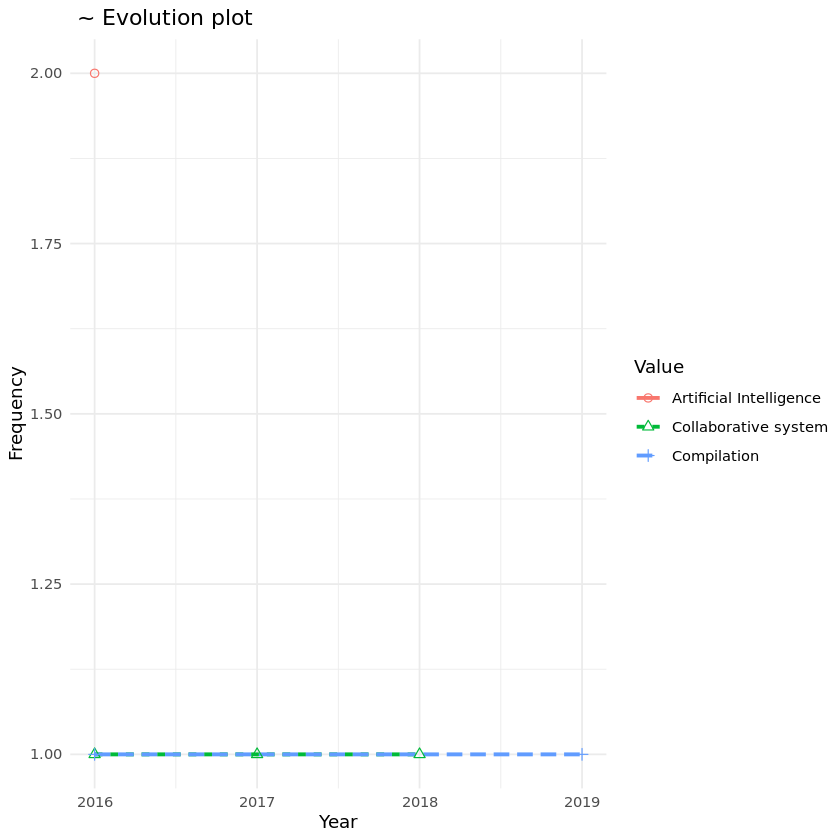


$Source.language


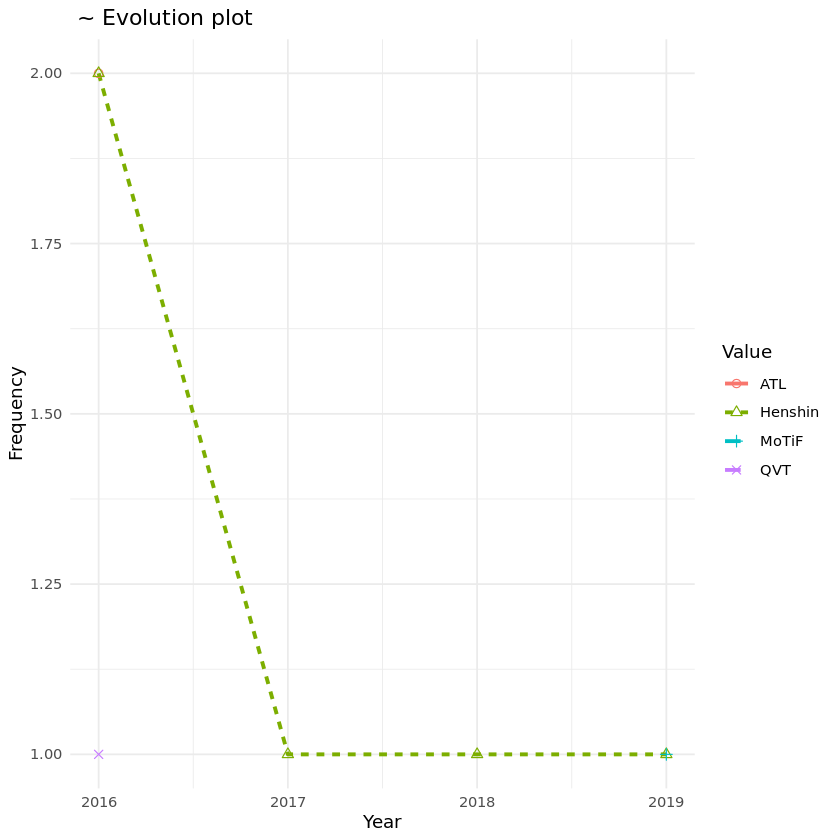


$Target.language


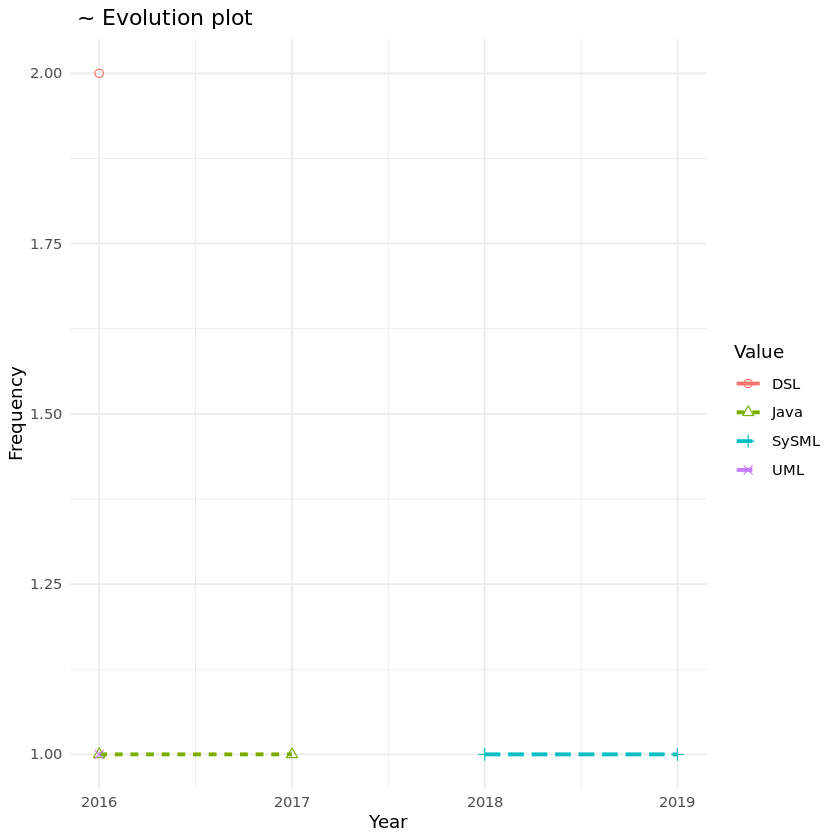


$Scope


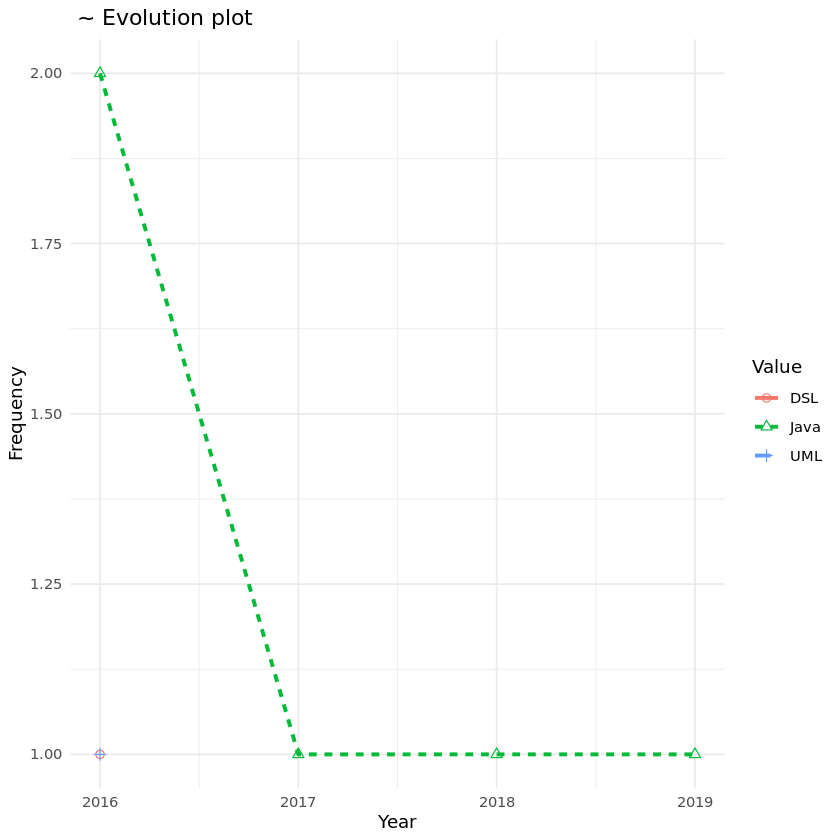


$Industrial


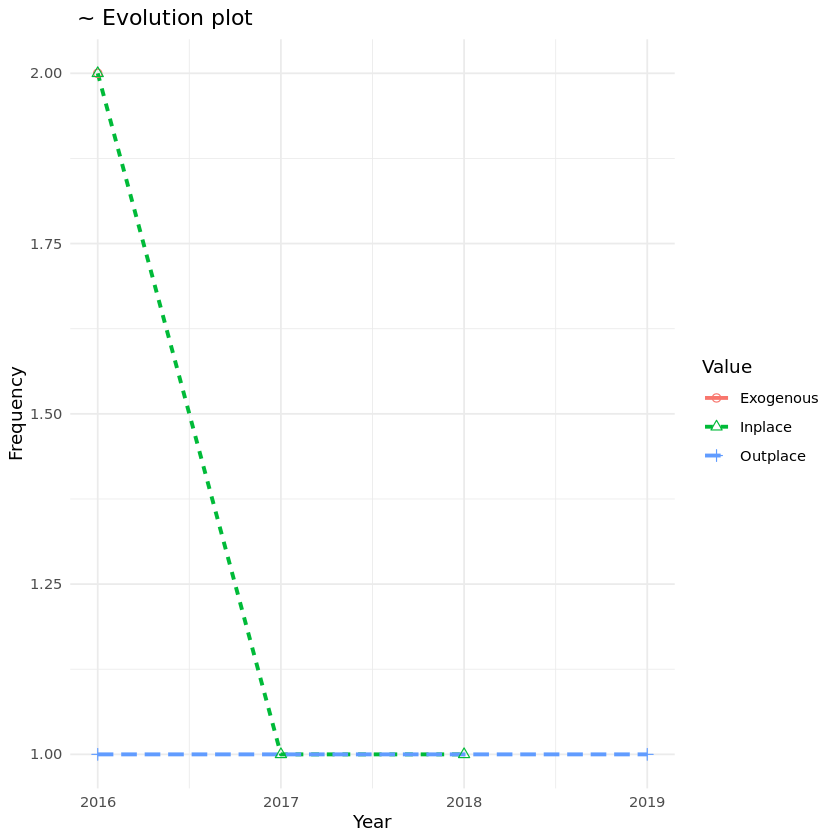


$Bidirectional


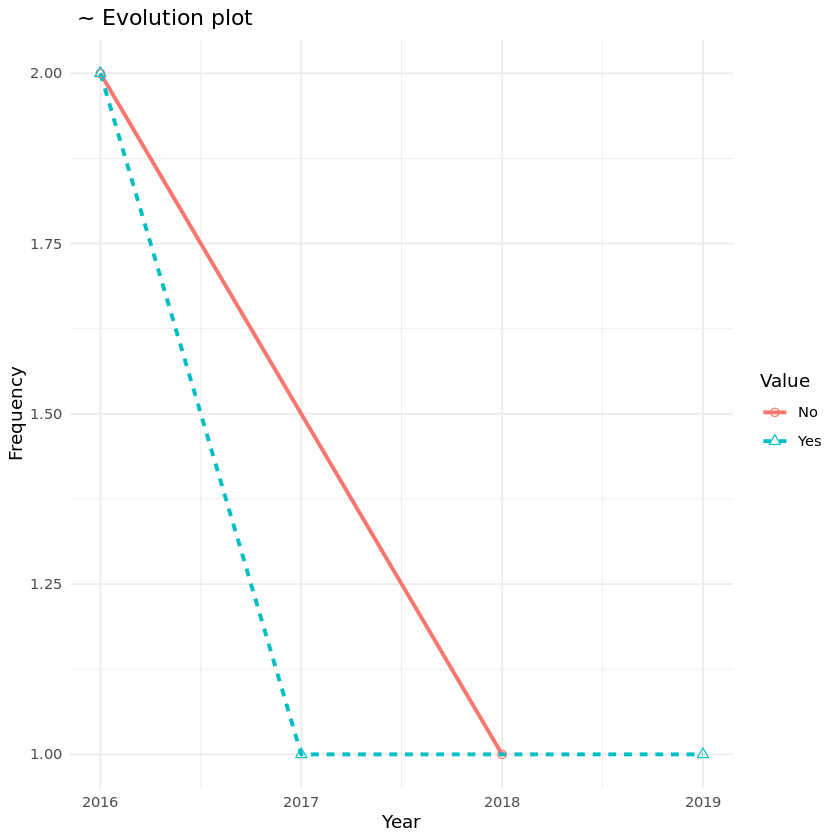


$Venue


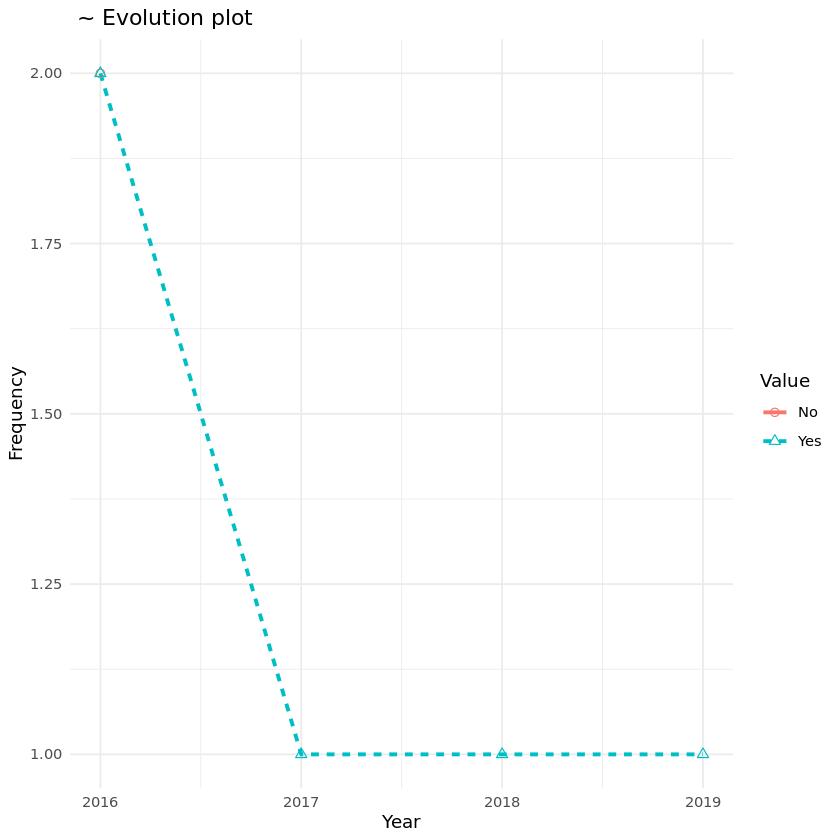


$Search.Type


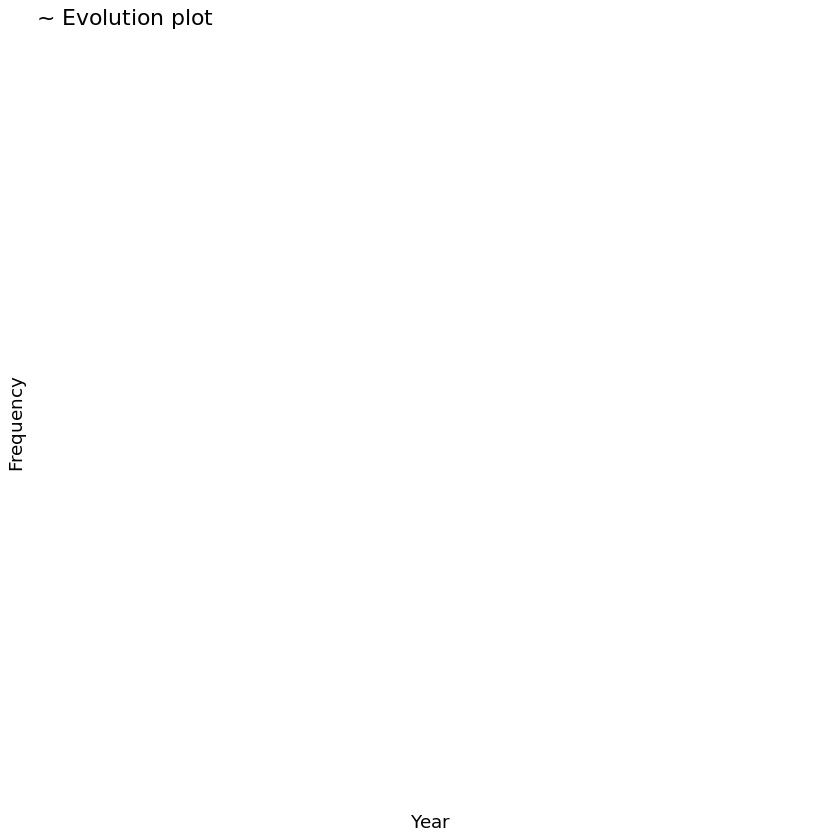

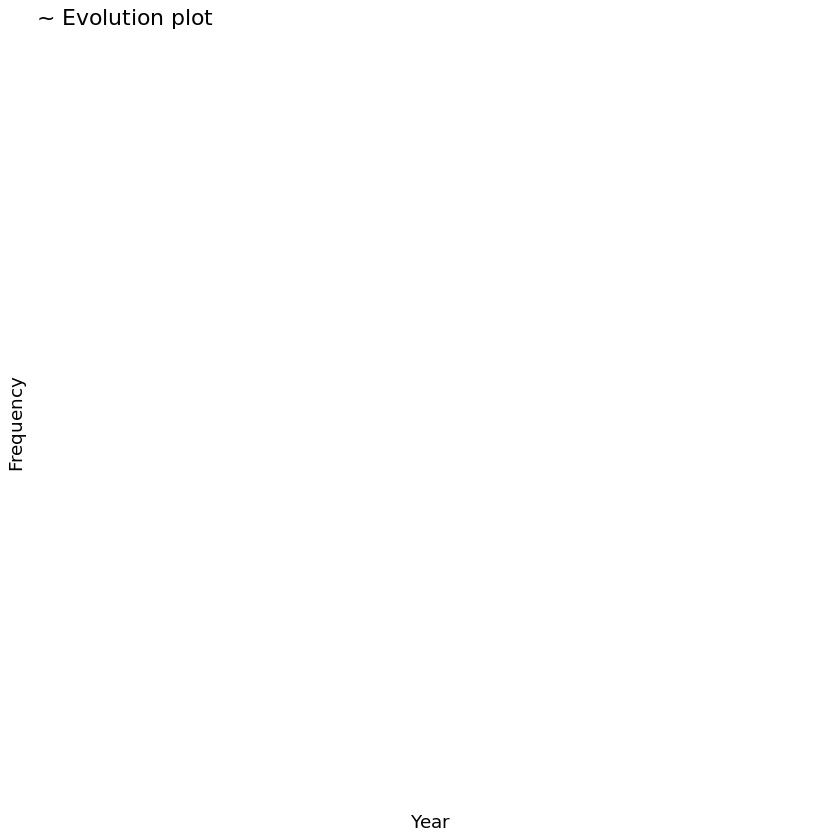

In [40]:
evolution_plot_vector <- list()

for (i in 1:nrow(nominal_df)) {
    # Evolution plots
    evolution_plot_vector[[nominal_df$Column_name[i]]] <- generate_evo_plot(relis_data, nominal_df, i)
}

print(evolution_plot_vector)

<h4><u>COMPARATIVE STATS</u></h4>

<h5 style="color:orange">Functions<h5>

In [ ]:
# Available functions
# Function to subset required data
beautify_data <- function(data, config_file, i, j) {
    subset_data <- data[, c(config_file$Column_name[i], config_file$Column_name[j])]
    colnames(subset_data) <- c("variable_1", "variable_2")

    subset_data <- subset_data[subset_data$variable_1 != "" & subset_data$variable_2 != "", ]

    subset_data <- subset_data %>%
        separate_rows(variable_1, sep = "\\s*\\|\\s*") %>%
        separate_rows(variable_2, sep = "\\s*\\|\\s*") %>%
        count(variable_1, variable_2, name = "Freq")

    return(subset_data)
}

# Function to generate stacked bar plots
generate_stacked_bar_plot <- function(data, config_file, i, j) {
    subset_data <- beautify_data(data, config_file, i, j)

    p <- ggplot(subset_data, aes(x = variable_1, y = Freq, fill = variable_2)) +
        geom_bar(stat = "identity") +
        labs(
            title = paste(config_file$Title[i], "and", config_file$Title[j], "~ Stacked bar plot"),
            x = config_file$Title[i], y = "Frequency", fill = config_file$Title[j]
        ) +
        theme_minimal()

    return(p)
}

# Function to generate grouped bar plots
generate_grouped_bar_plot <- function(data, config_file, i, j) {
    subset_data <- beautify_data(data, config_file, i, j)

    p <- ggplot(subset_data, aes(x = variable_1, y = Freq, fill = variable_2)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(
            title = paste(config_file$Title[i], "and", config_file$Title[j], "~ Grouped bar plot"),
            x = config_file$Title[i], y = "Frequency", fill = config_file$Title[j]
        ) +
        theme_minimal()

    return(p)
}

# Function to generate bubble charts
generate_bubble_chart <- function(data, config_file, i, j) {
    subset_data <- beautify_data(data, config_file, i, j)

    p <- ggplot(subset_data, aes(x = variable_1, y = variable_2, size = Freq)) +
        geom_point() +
        labs(
            title = paste(config_file$Title[i], "and", config_file$Title[j], "~ Bubble Chart"),
            x = config_file$Title[i], y = config_file$Title[j], size = "Frequency"
        ) +
        theme_minimal()

    return(p)
}



# Function to conduct Fisher's exact test
fisher_exact_test <- function(data, config_file, i, j) {
    subset_data <- beautify_data(data, config_file, i, j)
    if (nrow(subset_data) == 1 && is.na(subset_data$variable_1) && is.na(subset_data$variable_2)) {
        return(NA)
    }

    contingency_table <- xtabs(Freq ~ variable_1 + variable_2, data = subset_data)

    fisher_exact_test_result <- fisher.test(contingency_table, simulate.p.value = TRUE)

    return(fisher_exact_test_result)
}

# Function to conduct Shapiro Wilk's test
shapiro_wilk_test <- function(data, config_file, i) {
    subset_data <- data[[config_file$Column_name[i]]]
    shapiro_result <- shapiro.test(subset_data)

    return(shapiro_result)
}

# Function to conduct Spearman's correlation test
spearman_cor_test <- function(data, config_file, i, j) {
    column_1 <- data[[config_file$Column_name[i]]]
    column_2 <- data[[config_file$Column_name[j]]]

    spearman_result <- cor.test(column_1, column_2, method = "spearman", exact = FALSE)

    return(spearman_result)
}

# Function to conduct Pearson's correlation test
pearson_cor_test <- function(data, config_file, i, j) {
    column_1 <- data[[config_file$Column_name[i]]]
    column_2 <- data[[config_file$Column_name[j]]]

    pearson_result <- cor.test(column_1, column_2, method = "pearson")

    return(pearson_result)
}

<h5 style="color:#F0F8FF">Execution<h5>

In [ ]:
comp_distr_vector <- list()

# Generate plots for all possible combinations of nominal data
for (i in 1:nrow(nominal_df)) {
    comp_distr_vector[[nominal_df$Column_name[i]]] <- list()

    for (j in 1:nrow(nominal_df)) {
        if (j != i) {
            comp_distr_vector[[nominal_df$Column_name[i]]][[nominal_df$Column_name[j]]] <- beautify_data(relis_data, nominal_df, i, j)
        }
    }
}

In [ ]:
stacked_bar_plot_vector <- list()

In [ ]:
grouped_bar_plot_vector <- list()

In [ ]:
bubble_chart_vector <- list()

In [ ]:
fisher_exact_test_vector <- list()

In [ ]:
shapiro_wilk_test_vector <- list()

for (i in 1:nrow(continuous_df)) {
    shapiro_wilk_test_vector[[continuous_df$Column_name[i]]] <- shapiro_wilk_test(relis_data, continuous_df, i)
}

In [ ]:
pearson_cor_test_vector <- list()

In [ ]:
spearman_cor_test_vector <- list()